#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head())
display(data.info())
display(data.describe())
display(data.shape)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


(26496, 1)

In [4]:
#выполним ресемплирование данных по одному часу
#так как предсказываем кол-во заказоа на следующий час

data = data.resample('1H').sum()

## Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

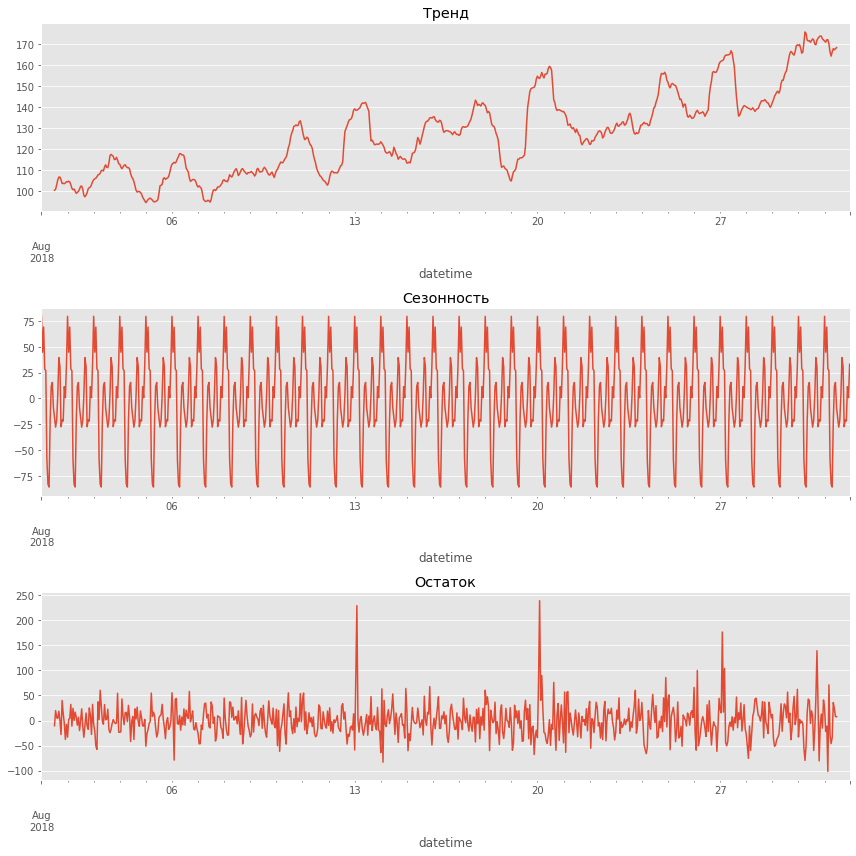

In [5]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(data['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остаток')
plt.tight_layout()

- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
- Случайная часть также имеет постояное среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
- Тренд показывает линейный рост количества заказов со временем. 

Text(0.5, 1.0, 'Тренд')

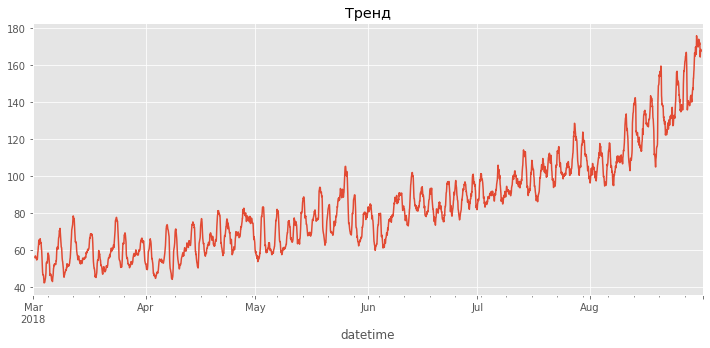

In [6]:
#Построим тренд для всего временного ряда, чтобы увидеть полную картину
plt.style.use('ggplot')
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

Тренд имеет более сложную зависимость от времени (сложно оценить по данной выборке какая она именно). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).

Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

***Вывод***

Данные представляют собой количество вызовов такси каждые час за полгода с марта по август включительно. В данных есть тренд - количество заказов растет от марта к августу, хотя есть вероятность, что это сезонные колебания. 

## Обучение

In [7]:
#В качестве базовой модели будем предсказывать новые значения предыдущими

train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE базовой модели:", round(rmse_base, 3))

RMSE базовой модели: 53.368


In [8]:
#проверим предсказания по среднему значению

pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE базовой модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE базовой модели: 74.42015786913375


Результат по предыдущим значениям лучше, поэтому будем использовать его.

Напишем функцию для создания обучающих признаков. Создадим признаки *day*, *dayofweek*. А также признаки для скользящего среднего *rolling_mean* (с размером окна *rolling_mean_size*) и *lag_i* для признаков отстающего значения.

In [9]:
def make_features(data_1, max_lag, rolling_mean_size):
    df = data_1.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

df = make_features(data, 30, 50)

**Линейная регрессия**

Разделим признаки в соотношении 9:1 (10% тестовой выборки)

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

In [11]:
train.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86


In [12]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lm = LinearRegression()
lm.fit(X_train, y_train)
preds_train = lm.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)

preds_test = lm.predict(X_test)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, preds_test) ** 0.5)

RMSE на обучающей выборке: 24.107441665527308
RMSE на тестовой выборке:  39.82156637969242


In [13]:
#Подберём параметры для линейной регрессии более точно

best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        df = make_features(data, lag, roll_size)
        train, test = train_test_split(df, shuffle=False, test_size=0.2)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']

        lm = LinearRegression()
        lm.fit(X_train, y_train)

        preds_test = lm.predict(X_test)
        rmse = mean_squared_error(y_test, preds_test) ** 0.5
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на тестовой выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на тестовой выборке: 35.694169636798115, максимальное смещение 96, размер скользящего окна 11


**Lasso**

Попробуем обучить модель с регуляризацией.

In [14]:
def model_build(model):
    best_lag = 0
    best_roll_size = 0
    best_alpha = 0
    best_rmse = 48
    for lag in range(1, 101, 5):
        for roll_size in range(1, 101, 5):
            for alpha in np.arange(0.1, 1, 0.2):

                df = make_features(data, lag, roll_size)
                train, test = train_test_split(df, shuffle=False, test_size=0.2)
                train = train.dropna()
                X_train = train.drop('num_orders', axis = 1)
                y_train = train['num_orders']
                X_test = test.drop('num_orders', axis = 1)
                y_test = test['num_orders']
                
                if model == 'Lasso' :
                    lm = Lasso(alpha=alpha)
                elif model == 'Ridge' :
                    lm = Ridge(alpha=alpha)
                lm.fit(X_train, y_train)

                preds_test = lm.predict(X_test)
                rmse = mean_squared_error(y_test, preds_test) ** 0.5
                if rmse < best_rmse :
                    best_rmse = rmse
                    best_lag = lag
                    best_roll_size = roll_size
                    best_alpha = alpha
    return best_rmse, best_lag, best_roll_size, best_alpha

In [15]:
best_rmse_ls, best_lag_ls, best_roll_size_ls, best_alpha_ls = model_build("Lasso")
print(f"Lasso")
print(f"RMSE на тестовой выборке: {best_rmse_ls}, максимальное смещение {best_lag_ls}, размер скользящего окна {best_roll_size_ls}")
print(f"Коэффициент регуляризации: {best_alpha_ls}")

RMSE на тестовой выборке: 35.67281060216996, максимальное смещение 96, размер скользящего окна 41
Коэффициент регуляризации: 0.9000000000000001


In [16]:
best_rmse_rg, best_lag_rg, best_roll_size_rg, best_alpha_rg = model_build("Ridge")
print(f"Ridge")
print(f"RMSE на тестовой выборке: {best_rmse_rg}, максимальное смещение {best_lag_rg}, размер скользящего окна {best_roll_size_rg}")
print(f"Коэффициент регуляризации: {best_alpha_rg}")

Ridge
RMSE на тестовой выборке: 35.694169666362185, максимальное смещение 96, размер скользящего окна 1
Коэффициент регуляризации: 0.1


## Тестирование

Проверка на тестовой выборке была проведена в предыдущем пункте. Сейчас соберём данные в таблицу и проанализируем результат.

In [17]:
stats = pd.DataFrame([['Базовая', round(rmse_base, 3), 1, 0, np.nan],
                      ['Linear Regression', round(best_rmse_lm, 3), best_lag_lm, best_roll_size_lm, np.nan],
                      ['Lasso', round(best_rmse_ls, 3), best_lag_ls, best_roll_size_ls, best_alpha_ls],
                      ['Ridge', round(best_rmse_rg, 3), best_lag_rg, best_roll_size_rg, best_alpha_rg]],
                    columns = ['model', 'rmse', 'max_lag', 'roll_size', 'alpha'])

In [18]:
stats

,model,rmse,max_lag,roll_size,alpha
0,Базовая,53.368,1,0,NaN
1,Linear Regression,35.694,96,11,NaN
2,Lasso,35.673,96,41,0.9
3,Ridge,35.694,96,1,0.1


Для предсказаний модели Lasso с параметром регуляризации alpha=0.9 построим графики зависимостей целевого признака и предсказаний от времени. Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 10 дней

In [20]:
df = make_features(data, 96, 41)
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lasso = Lasso(alpha=0.9)
lasso.fit(X_train, y_train)
preds_test = pd.Series(lasso.predict(X_test), index = y_test.index, name='preds')

df_preds = pd.concat([y_test, preds_test], axis=1)
df_preds.head()

,num_orders,preds
datetime,,
2018-07-26 04:00:00,131,127.387869
2018-07-26 05:00:00,83,75.378455
2018-07-26 06:00:00,21,48.722166
2018-07-26 07:00:00,39,65.843009
2018-07-26 08:00:00,80,61.754457


<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

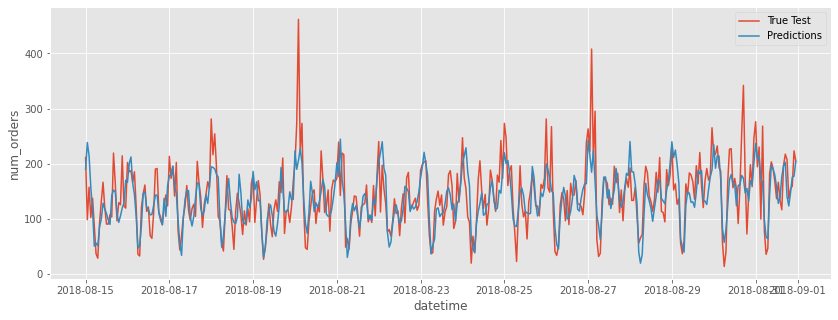

In [21]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data = df_preds['2018-08-15':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True Test')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')

По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редки пики в данных (возможно, рост спроса на такси по выходным или праздничным дням) предсказать не может. 

***Вывод***

Все линейные модели показали похожий результат по RMSE.

Максимальное смещение ограничено значением 100 ввиду сложности модели. Дальше показатель RMSE не сильно растёт.

Как и предполагалось, наилучшие результат даёт скользящее окно размером ~40-50 часов (около двух дней, это значение хорошо сглаживает кривую тренда, судя по графику.)

С помощью модели Lasso удалось уменьшить RMSE на 33% относительно Базовой модели.

По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редкие пики в данных предсказать не может.